# Défi EGC 2024

### import

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scripts.data_frame_generator import generate_external_time_series,generate_global_time_series, generate_blockchain_by_actor, min_max_norm,std_scale
from scripts.best_correlation import compute_best_correlation,compute_best_correlation_by_col,display_correlation_by_col
from scripts.best_correlation import get_corr_mat
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Récupération et prétraitement de de la donnée

In [5]:
# Récupération des séries temporelles extérieures.
external_df = generate_external_time_series("timeseries/external.csv")

# Récupération des données des 100 plus grands acteurs de la blockchain.
block_chain_by_actor_df = generate_blockchain_by_actor('timeseries/blockchain_by_actor.csv')

## Travail sur la donnée

### Affichage du HashRate et du prix en dollars

In [46]:
# Normalisation de la data frame
std_scaler = StandardScaler()
df_normalized = std_scaler.fit_transform(external_df)
df_normalized = pd.DataFrame(np.array(df_normalized, dtype=np.float64), columns=external_df.columns,index=external_df.index)

# Lissage de la série temporelle
df_rolling = df_normalized.rolling(window=7).mean()

# Création de la figure Plotly Express
fig = px.line(df_rolling,x=df_rolling.index,  y=["HashRate", "PriceUSD"],
              title="Evolution du HashRate et du prix du Bitcoin",
              labels={"value": "Valeur normalisée", "variable": "Variables", "Date": df_rolling.index.name},
              template="simple_white")

# Affichage de la figure
fig.show()

#### Evaluation des correlation entre HashRate et le prix du Bitcoin en Dollar
En regardant les précédentes courbes affichées on peut remarquer que le HashRate et le prix en dollars augmentent de mannière comparable. Mesurons maintenant leur niveau de corrélation par la corrélation de Pearson.

In [15]:
correlation_matrix = external_df.corr()
correlation_matrix

,PriceUSD,HashRate
PriceUSD,1.000000,0.937447
HashRate,0.937447,1.000000


On peut remarquer ici que le score de correlation de Pearson entre le PriceUSD et le HashRate est de 0.93, ce qui signifie que les PriceUSD et Hashrate on une relation linéaire qui est proche.

### Travail sur les 100 principaux acteurs de la blockcahin

In [6]:
column_to_analyze = 'received'
block_chain_by_actor_df.groupby('identity')[[column_to_analyze]].sum().sort_values(by=column_to_analyze, ascending=False).head()

,received
identity,
Huobi.com,1.313671e+15
ePay.info_CoinJoinMess,1.188925e+15
Bitstamp.net,6.997821e+14
BTC-e.com,5.370579e+14
OKCoin.com,4.589288e+14


In [8]:
short_blochain_df = block_chain_by_actor_df.copy()

On veut chercher ici à trouver des correlation sur l'évolution de chaque acteurs entre eux à savoir si deux acteurs ont une activité qui évolue de manière similaire comme il a été fait pour l'analyse du HashRate et du cours du Bitcoin.

In [31]:
df_unstacked = short_blochain_df.groupby(['date', 'identity'])[column_to_analyze].mean().unstack()
actor_correlation_matrix = df_unstacked.corr()
np.fill_diagonal(actor_correlation_matrix.values,0)

In [32]:
s = actor_correlation_matrix.stack()
max_index = s.idxmax()[0]
max_col = actor_correlation_matrix.loc[max_index].idxmax()
max_value = actor_correlation_matrix[max_col].loc[max_index]
max_index, max_col

('BTCC.com', 'BtcTrade.com')

On remarque une augmentation du nombre de transactions vers avril 2016 ainsi qu'une baisse vers juillet dans les deux courbes. On notera que le nombre de transaction n'est pas du même ordre de grandeur.

On peut alors se poser la question si l'activité de certains groupes d'acteurs sont corrélées entre elles.

In [34]:
# Nom de la colonne à analyser dans le block_chain_by_actor_df
column_to_analyze = 'received'
# Appel d'une fonction déterminant le couple d'acteurs ayant le meilleur coefficient de corrélation 
max_index,max_col, max_value = compute_best_correlation_by_col(block_chain_by_actor_df,column_to_analyze)
print(f"La valeur maximale est {max_value} et elle se trouve à l'index  '{max_index}' dans la colonne '{max_col}'")

La valeur maximale est 0.9021413876901954 et elle se trouve à l'index  'BTCC.com' dans la colonne 'BtcTrade.com'


#### Affichage des données corrélées

In [53]:
column_to_analyze = 'received'
max_index, max_col, max_value = compute_best_correlation_by_col(block_chain_by_actor_df, column_to_analyze)
key1, key2 = max_col, max_index
window = 14

# Filtrage des données pour la première identité
df1 = block_chain_by_actor_df[block_chain_by_actor_df['identity'] == key1]
df1 = df1.reset_index(drop=True)
df1[column_to_analyze] = df1[column_to_analyze].rolling(window=window).mean()

# Filtrage des données pour la deuxième identité
df2 = block_chain_by_actor_df[block_chain_by_actor_df['identity'] == key2]
df2 = df2.reset_index(drop=True)
df2[column_to_analyze] = df2[column_to_analyze].rolling(window=window).mean()

# Fusion des deux dataframes en un seul
df = pd.concat([df1, df2])

# Création de la figure Plotly Express
fig = px.line(df, x=df.index, y=column_to_analyze, color="identity",
              title=f"Comparison of '{column_to_analyze}' between {key1} and {key2}",
              labels={"value": f"{column_to_analyze} (rolling mean)", "index": "date"})

# Affichage de la figure
fig.show()
df1.index

RangeIndex(start=0, stop=912, step=1)

##### Analyse des répartitions des acteurs sur le réseau

In [84]:
df = block_chain_by_actor_df.groupby(by='identity').sum()

def plot_rep(pivot_df: pd.DataFrame, colonne:str):
    fig = px.pie(pivot_df,values=colonne,names=pivot_df.index)
    fig.update_traces(textposition='inside')
    fig.update_layout(title_text=f'{colonne} repartition.')
    fig.show()

#plot_rep(pivot_df, 'received')
cols = 2
rows = 1
fig = make_subplots(rows=rows, cols=cols,specs=rows*[  cols*[{'type': 'domain'}] ],subplot_titles=['Frais', 'Dépenses'])

# Ajouter le diagramme camembert pour la colonne 'sum_fee'
fig.add_trace(go.Pie(labels=df.index, values=df['sum_fee'], name= 'Frais'), row=1, col=1)

# Ajouter le diagramme camembert pour la colonne 'spent'
fig.add_trace(go.Pie(labels=df.index, values=df['spent'], name='Dépenses'), row=1, col=2)

# Mettre à jour les options de layout
fig.update_traces(textposition='inside')
fig.update_layout(title_text='Repartition des frais et dépenses par date')
fig.show()



In [72]:
grouped_df = block_chain_by_actor_df.groupby('identity')[['received']].mean()
grouped_df = grouped_df.sort_values('received',ascending=False)
fig = px.bar(grouped_df.head(10), y=['received'], barmode='group')

# Afficher le graphique
fig.show()

,received
identity,
Huobi.com,1.440429e+12
ePay.info_CoinJoinMess,1.303645e+12
Bitstamp.net,7.673049e+11
BTC-e.com,5.888792e+11
OKCoin.com,5.032114e+11
...,...
18972,2.779030e+08
72472408,2.503300e+08
419,9.187516e+07


In [68]:
SATOSH_PER_BTC = 1e-8
merge_df = pd.merge(block_chain_by_actor_df, external_df[['PriceUSD']], left_index=True, right_index=True)
merge_df['sentUSD'] = merge_df['sent']*SATOSH_PER_BTC*merge_df['PriceUSD']
merge_df['receivedUSD'] =  merge_df['received']*SATOSH_PER_BTC*merge_df['PriceUSD']
merge_df['sum_feeUSD'] =  merge_df['sum_fee']*SATOSH_PER_BTC*merge_df['PriceUSD']
merge_df[['identity','sent','sentUSD', 'receivedUSD', 'sum_feeUSD']]



,identity,sent,sentUSD,receivedUSD,sum_feeUSD
date,,,,,
2015-01-02,SimpleCoin.cz,1.532397e+09,4.841496e+03,2.458636e+03,0.189566
2015-01-02,CoinSpot.com.au,2.172600e+08,6.864172e+02,2.688125e+03,0.157971
2015-01-02,HappyCoins.com,1.161538e+09,3.669795e+03,3.655590e+03,0.195869
2015-01-02,CoinGaming.io,6.772445e+09,2.139705e+04,2.153421e+04,2.473832
2015-01-02,OKCoin.com,1.234305e+11,3.899698e+05,3.799073e+05,5.213055
...,...,...,...,...,...
2017-06-30,BTCJam.com,1.043491e+06,2.559383e+01,2.915156e+01,3.557732
2017-06-30,417,1.000000e+11,2.452712e+06,3.114666e+06,78.417129
2017-06-30,CoinTrader.net_LocalBitcoins.com,4.164831e+10,1.021513e+06,1.324253e+06,305.970802


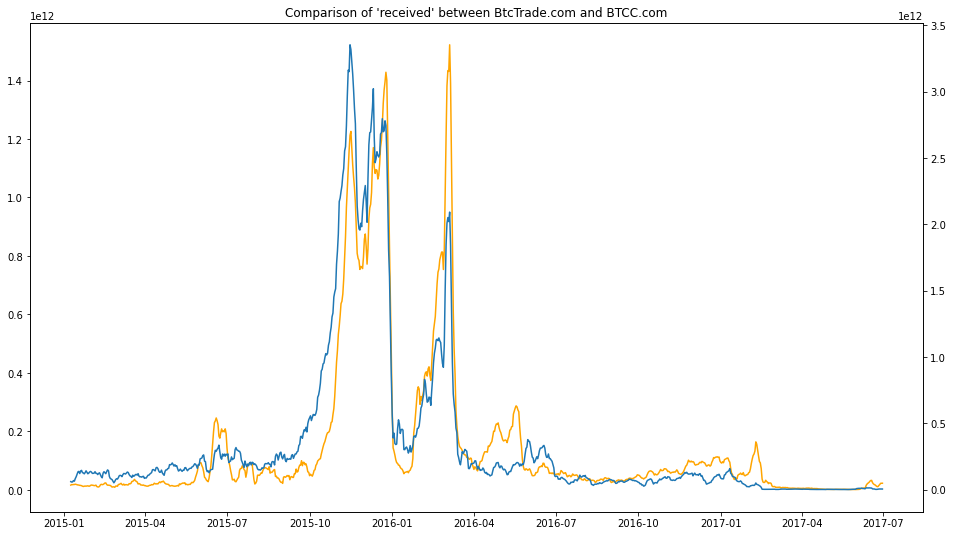

In [ ]:
display_correlation_by_col(merge_df.drop("PriceUSD",axis=1),window_size=7,column_to_analyze='received')

In [ ]:
merge_df['balanceUSD'] = merge_df['receivedUSD'] - merge_df['sentUSD'] 
merge_df['balance'] = merge_df['received'] - merge_df['sent'] 